In [4]:
import numpy as np
from scipy import ndimage
from matplotlib import pyplot as plt
# from sklearn.metrics.pairwise import euclidean_distances
from scipy.spatial.distance import cdist
from sklearn import datasets
from collections import OrderedDict 
import itertools
from sklearn import manifold, datasets

## Pull Data

In [5]:
digits = datasets.load_digits(n_class=10)
X = digits.data[0:500,:]
y = digits.target[0:500]
n_samples, n_features = X.shape
X_red = manifold.SpectralEmbedding(n_components=2).fit_transform(X)

In [6]:
X.shape

(500, 64)

<Figure size 432x288 with 0 Axes>

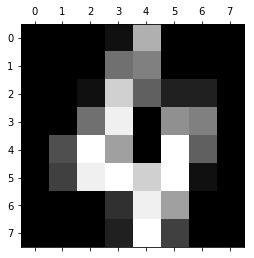

In [7]:
plt.gray() 
plt.matshow(digits.images[4]) 
plt.show() 

In [8]:
# # Visualize the clustering
# def plot_clustering(X_red, labels, title=None):
#     x_min, x_max = np.min(X_red, axis=0), np.max(X_red, axis=0)
#     X_red = (X_red - x_min) / (x_max - x_min)

#     plt.figure(figsize=(6, 4))
#     for i in range(X_red.shape[0]):
#         plt.text(X_red[i, 0], X_red[i, 1], str(y[i]),
#                  color=plt.cm.nipy_spectral(labels[i] / 10.),
#                  fontdict={'weight': 'bold', 'size': 9})

#     plt.xticks([])
#     plt.yticks([])
#     if title is not None:
#         plt.title(title, size=17)
#     plt.axis('off')
#     plt.tight_layout(rect=[0, 0.03, 1, 0.95])
# plot_clustering(X_red = , labels, title=None)

## Coding up Hierarchical Clustering

In [13]:
def fuseClusters(i, j, clusterSetList):
#     print(clusterSetList)
#     print("fuse indices", i, j)
#     print(clusterSetList[i])
#     print(clusterSetList[j])
    assert clusterSetList[i].intersection(clusterSetList[j]) == set(), "clusters with overlapping elements"
    clusterSet = clusterSetList[i].union(clusterSetList[j])
    assert len(clusterSet) > 1, "why are you adding a cluster of size 1"
#     print("cluster set", clusterSet)
#     clusterSet = set()
#     iSetFound = False
#     jSetFound = False
#     for clusterItems in reversed(clusterSetList):
#         if i in clusterItems:
#             clusterSet.update(clusterItems)
#             iSetFound = True
#         if j in clusterItems:
#             clusterSet.update(clusterItems)
#             jSetFound = True
    
#     if not iSetFound:
#         clusterSet.add(i)# no cluster contains this element, so this is the first time it is added
#     if not jSetFound:
#         clusterSet.add(j)# no cluster contains this element, so this is the first time it is added      
    return(clusterSet)

def clusterSanityCheck(clusterSetList, n):
    previousClusters = []
    for i in range(n):
#         print("looking at elemnt: {}".format(i))
        prevSet = set()
        for clusterSet in clusterSetList:
            if i == 0:
                assert clusterSet not in previousClusters, "cluster exists twice in cluster list\n{}".format(clusterSet)
                previousClusters.append(clusterSet)
            if i in clusterSet:
#                 print("prev",prevSet)
#                 print("cur",clusterSet)
                assert prevSet.issubset(clusterSet), "element {} might occur in multiple sets".format(i)
                prevSet = clusterSet
#                 print("*********")
    return(True)

def calculateClusterDistances(X, clusterSetList, clusterIdx):
    n = len(clusterSetList)
#     print(n)
    clusterDistances = [0]*n
#     print(list(clusterSetList[clusterIdx]))
    clusterIdxSubMat = X[list(clusterSetList[clusterIdx]), :]
    for idx, clusterSet in enumerate(clusterSetList):
        allDistances = cdist(clusterIdxSubMat, X[list(clusterSet), :])
        clusterDistances[idx] = np.average(allDistances)
    clusterDistances[clusterIdx] = np.Inf
    return(clusterDistances)


n, m = X_red.shape
# print(X.shape)
infDiag = np.zeros((n, n), float)
np.fill_diagonal(infDiag, np.inf)

singleClusterSetList = [set([x]) for x in range(n)]
singleClusterSetList.extend([set()]*(n-1))# a list containing the most recent cluster at each step
clusterSetList = singleClusterSetList
# print(len(clusterSetList))

singleClusterHeight = [0 for x in range(n)]
singleClusterHeight.extend([0]*(n-1))
clusterHeightList = singleClusterHeight

pairWiseDistMat = cdist(X_red, X_red, metric = "euclidean") + infDiag
currentClusters =  [set([x]) for x in range(n)]# single clusters

clusterIndx = 0 + n
for i in range(0 + n, n-1 + n):#reversed(range(2, n)):
    i_min,j_min = np.unravel_index(pairWiseDistMat.argmin(), pairWiseDistMat.shape)
    height = pairWiseDistMat[i_min,j_min]
#     pairWiseDistMat[i_min, j_min] = np.Inf# makes sure that these two can never be added to the same cluster again
#     pairWiseDistMat[j_min, i_min] = np.Inf# symmetric matrix
    clusterSet = fuseClusters(i_min, j_min, currentClusters)
    # deleting rows and columns of distance mat corresponding to i_min and j_min clusters
    pairWiseDistMat = np.delete(pairWiseDistMat, [i_min, j_min], axis = 0)
    pairWiseDistMat = np.delete(pairWiseDistMat, [i_min, j_min], axis = 1)
    currentClusters = [clust for idx, clust in enumerate(currentClusters) if idx not in [i_min, j_min]]
    assert clusterSet not in clusterSetList, "about to add a set twice.\n{}".format(clusterSet)
    currentClusters.append(clusterSet)
    newPairWiseDistance = calculateClusterDistances(X = X_red, clusterSetList = currentClusters, clusterIdx = -1)
#     print(len(newPairWiseDistance))
    pairWiseDistMat = np.pad(pairWiseDistMat, (0,1), 'constant', constant_values=(23))
    pairWiseDistMat[-1,:] = newPairWiseDistance
    pairWiseDistMat[:,-1] = newPairWiseDistance
#     print("pairwise dist mat shape: {}".format(pairWiseDistMat.shape))
#     for i_update, j_update in itertools.combinations(clusterSet, 2):
#         pairWiseDistMat[i_update, j_update] = np.Inf# makes sure that these two can never be added to the same cluster again
#         pairWiseDistMat[j_update, i_update] = np.Inf# symmetric matrix
#     print("********")
    clusterSetList[clusterIndx] = clusterSet
    clusterHeightList[clusterIndx] = height
    clusterIndx += 1
# singleClusterSetList = [set([x]) for x in range(n)]
# singleClusterSetList.extend(clusterSetList)
# clusterSetList = singleClusterSetList
clusterSanityCheck(clusterSetList, n)

assert len(clusterHeightList) == len(clusterSetList), "each cluster needs a merge height"

In [14]:
def clusterAssignments(clusterSetList, clusterHeightList, cutOffheight):
    maximalClusterSets = []
    n = 0
    for clusterSetCandidate, clusterHeight in zip(reversed(clusterSetList), reversed(clusterHeightList)):
        if clusterHeight > cutOffheight:
            continue
        notASubset = True
        for clusterToCheck in maximalClusterSets:
            if clusterSetCandidate.issubset(clusterToCheck):
                notASubset = False
        if notASubset:
#             print("appending")
            maximalClusterSets.append(clusterSetCandidate)
            n += len(clusterSetCandidate)
    print(n)
    clusterMapIdxs = [-1]*n
    for clustNum, clusterSet in enumerate(maximalClusterSets):
        for elem in clusterSet:
            clusterMapIdxs[elem] = clustNum
    return(maximalClusterSets, clusterMapIdxs)

In [190]:
clusterHeightList

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [17]:
maximalClusterSets, clusterLabels = clusterAssignments(clusterSetList, clusterHeightList, cutOffheight = 0.0035)
print(len(maximalClusterSets))
print(len(clusterLabels))

500
11
500


In [20]:
n = 0
for elem in clusterSetList:
    n += len(elem)
print(n)

272106


In [46]:

temp = set()
for elem in clusterSetList:
    temp.update(elem)

In [48]:
len(temp)

500

In [16]:
clustering.labels_

array([0, 1, 1, ..., 1, 1, 1])

In [187]:
clusterLabels

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


Automatically created module for IPython interactive environment
average :	0.01s


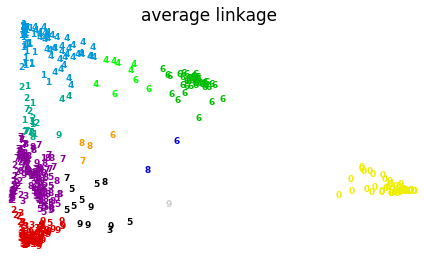

In [18]:
print(__doc__)
from time import time

import numpy as np
from scipy import ndimage
from matplotlib import pyplot as plt

from sklearn import manifold, datasets

# digits = datasets.load_digits(n_class=10)
# X = digits.data
# y = digits.target
n_samples, n_features = X.shape

# np.random.seed(0)

# def nudge_images(X, y):
#     # Having a larger dataset shows more clearly the behavior of the
#     # methods, but we multiply the size of the dataset only by 2, as the
#     # cost of the hierarchical clustering methods are strongly
#     # super-linear in n_samples
#     shift = lambda x: ndimage.shift(x.reshape((8, 8)),
#                                   .3 * np.random.normal(size=2),
#                                   mode='constant',
#                                   ).ravel()
#     X = np.concatenate([X, np.apply_along_axis(shift, 1, X)])
#     Y = np.concatenate([y, y], axis=0)
#     return X, Y


# X, y = nudge_images(X, y)


#----------------------------------------------------------------------
# Visualize the clustering
def plot_clustering(X_red, labels, title=None):
    x_min, x_max = np.min(X_red, axis=0), np.max(X_red, axis=0)
    X_red = (X_red - x_min) / (x_max - x_min)

    plt.figure(figsize=(6, 4))
    for i in range(X_red.shape[0]):
        plt.text(X_red[i, 0], X_red[i, 1], str(y[i]),
                 color=plt.cm.nipy_spectral(labels[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})

    plt.xticks([])
    plt.yticks([])
    if title is not None:
        plt.title(title, size=17)
    plt.axis('off')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

#----------------------------------------------------------------------
# 2D embedding of the digits dataset
# print("Computing embedding")
# X_red = manifold.SpectralEmbedding(n_components=2).fit_transform(X)
# print("Done.")

from sklearn.cluster import AgglomerativeClustering

for linkage in ["average"]:#('ward', 'average', 'complete', 'single'):
    clustering = AgglomerativeClustering(linkage=linkage, n_clusters=10)
    t0 = time()
    clustering.fit(X_red)
    print("%s :\t%.2fs" % (linkage, time() - t0))

    plot_clustering(X_red, clusterLabels, "%s linkage" % linkage)


plt.show()


average :	0.01s


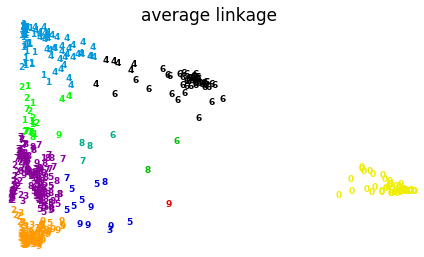

In [19]:
for linkage in ["average"]:#('ward', 'average', 'complete', 'single'):
    clustering = AgglomerativeClustering(linkage=linkage, n_clusters=10)
    t0 = time()
    clustering.fit(X_red)
    print("%s :\t%.2fs" % (linkage, time() - t0))

    plot_clustering(X_red, clustering.labels_, "%s linkage" % linkage)


plt.show()

In [180]:
X.shape

(2000, 64)

In [179]:
X_red.shape

(2000, 2)

In [174]:
clustering.labels_

array([0, 1, 1, ..., 1, 1, 1])

In [15]:
X_red

array([[ 1.68457127e-03,  8.20089489e-04],
       [-7.73917510e-04, -6.19286901e-04],
       [-8.02535481e-04, -3.84946042e-04],
       ...,
       [-6.77824577e-04, -5.65821880e-04],
       [ 2.95325525e-04,  6.11900997e-04],
       [-1.61394905e-04, -6.84574553e-05]])

In [195]:
maximalClusterSets = clusterAssignments(clusterSetList, clusterHeightList, cutOffheight = 24)
print(len(maximalClusterSets))

12


In [192]:
maximalClusterSets

[{0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109,
  110,
  111,
  112,
  113,
  114,
  115,
  116,
  117,
  118,
  119,
  120,
  121,
  122,
  123,
  124,
  125,
  126,
  127,
  128,
  129,
  130,
  131,
  132,
  133,
  134,
  135,
  136,
  137,
  138,
  139,
  140,
  141,
  142,
  143,
  144,
  145,
  146,
  147,
  148,
  149,
  150,
  151,
  152,
  153,
  154,
  155,
  156,
  157,
  158,
  159,
  160,
 

In [147]:
a = set([1, 2, 3, 389874])
b = set([2, 389874, 3, 1])
a.add(3)
a.update(b)
print(a)

{1, 2, 3, 389874}


In [148]:
temp = [a]
a in temp

True

In [149]:
a

{1, 2, 3, 389874}

In [150]:
b

{1, 2, 3, 389874}

In [78]:
i_min,j_min = np.unravel_index(pairWiseDistMat.argmin(), pairWiseDistMat.shape)
pairWiseDistMat[i,j]

5.291502622129181

In [85]:
from collections import OrderedDict 
print("\nThis is an Ordered Dict:\n") 
od = OrderedDict() 
od['a'] = 1
od['b'] = 2
od['c'] = 3
od['d'] = 4
  
for key, value in reversed(od.items()): 
    print(key, value)


This is an Ordered Dict:

d 4
c 3
b 2
a 1


In [40]:
myDist = euclidean_distances(X)

In [46]:
for i in reversed(range(2, 10)):
    print(i)

9
8
7
6
5
4
3
2


In [16]:
y

array([0, 1, 2, ..., 8, 9, 8])

In [31]:
from scipy.cluster.hierarchy import dendrogram, linkage
z = linkage(X, "ward")

In [32]:
z.shape

(1796, 4)

In [33]:
X.shape

(1797, 64)

In [34]:
z

array([[1.58500000e+03, 1.64800000e+03, 5.29150262e+00, 2.00000000e+00],
       [1.24700000e+03, 1.25000000e+03, 7.54983444e+00, 2.00000000e+00],
       [7.77000000e+02, 1.23700000e+03, 7.93725393e+00, 2.00000000e+00],
       ...,
       [3.55700000e+03, 3.58700000e+03, 4.88617614e+02, 5.37000000e+02],
       [3.58600000e+03, 3.58900000e+03, 5.36321258e+02, 1.26000000e+03],
       [3.59000000e+03, 3.59100000e+03, 6.91961227e+02, 1.79700000e+03]])

In [26]:
z[np.argsort(z[:, 0]), :]

array([[0.00000000e+00, 8.77000000e+02, 1.09544512e+01, 2.00000000e+00],
       [1.00000000e+00, 9.30000000e+01, 1.42478068e+01, 2.00000000e+00],
       [2.00000000e+00, 5.70000000e+01, 1.74355958e+01, 2.00000000e+00],
       ...,
       [3.58200000e+03, 3.58800000e+03, 4.50895559e+02, 6.95000000e+02],
       [3.58600000e+03, 3.58900000e+03, 5.36321258e+02, 1.26000000e+03],
       [3.59000000e+03, 3.59100000e+03, 6.91961227e+02, 1.79700000e+03]])

In [6]:
y

array([0, 1, 2, ..., 8, 9, 8])

## Choosing the Number of Clusters